# Bayesian Vector Autoregression

This notebook needs some cleaning up, but basically implements Bayesian vector autorgression using pymc.

The idea is that you have N time series that you want to predict forwards, and the model will assume that each can be predicted forwards assuming a linear combination of all time seires (taking some recent window).

After fitting a Bayesian version of the model, you can sample from posteriors to predict how the time series will likely evolve in the future

## Import some modules

In [1]:
import numpy as np
import pandas as pd
import os
import pymc as pm
import matplotlib.pyplot as plt
import arviz as az


## Load data

In [2]:
data_dir = '/Users/dominicbates/Documents/Github/statistical-analysis-templates/data/'
df = pd.read_csv(data_dir+'dom_cleaned_economic_data_2025_feb.csv')

# Make percentage YoY change relative
df['economy|net_debt|PSND_perc_gdp_YoY'] -= 100
df['economy|wages|weekly_earnings|SA_GBP_YoY'] -= 100
df['economy|unemployment_rate_16+_SA_YoY'] -= 100

# Rename for simplicity
df = df.rename(columns = {
    'economy|GDP_YoY_SA':'f|GDP|YoY',
    'economy|inflation|RPI_all_items':'f|rpi|YoY',
    'economy|net_debt|PSND_perc_gdp_YoY':'f|debt_perc_gdp|YoY',
    'economy|wages|weekly_earnings|SA_GBP_YoY':'f|wages|YoY',
    'economy|unemployment_rate_16+_SA_YoY':'f|unemployment|YoY'
})

# Filter to just pre-covid data 
df_train = df[df['pre_covid'] == True]


# df_train.head()

I am filtering the training data to remove some dodgy values around covid as I expect these might significantly affect the model fit

In [3]:
# Select variables to use in the model
variables = [f for f in list(df_train) if 'f|' in f]

# Choose manually
variables = [
    'f|GDP|YoY',
    'f|rpi|YoY',
    'f|debt_perc_gdp|YoY',
    'f|wages|YoY',
    'f|unemployment|YoY']

# Select just these variables from df_train
df_train = df_train[variables].astype(np.float64)  # Convert to float

variables

['f|GDP|YoY',
 'f|rpi|YoY',
 'f|debt_perc_gdp|YoY',
 'f|wages|YoY',
 'f|unemployment|YoY']

## BVAR model

In [15]:
# Number of lags (i.e. window size)
lags = 5

# Construct lagged features
def create_lagged_matrix(df, lags):
    """Creates a 3D matrix of lagged observations."""
    X = np.stack([df.shift(i).iloc[lags:].values for i in range(1, lags + 1)], axis=1).astype(np.float64)  # Ensure float dtype
    Y = df.iloc[lags:].values.astype(np.float64)  # Convert target as well
    return X, Y

# Training data in correct format (windowed values for time series)
X_train, Y_train = create_lagged_matrix(df_train, lags)

# Define coordinates for PyMC
coords = {
    "lags": range(1, lags + 1),
    "vars": variables,
    "cross_vars": variables,
    "time": range(Y_train.shape[0]),
}

# Define model
with pm.Model(coords=coords) as BVAR_model:

    # Store X_train as a shared PyMC variable
    X_shared = pm.Data("X_shared", X_train, mutable=False)
    
    # Priors
    intercept = pm.Normal("intercept", mu=0, sigma=10, dims=("vars",))
    lag_coefs = pm.Normal("lag_coefs", mu=0, sigma=10, dims=("lags", "vars", "cross_vars"))
    noise = pm.HalfNormal("noise", sigma=10, dims=("vars",))

    # Expected values using matrix multiplication
    ar_terms = []
    for var_idx in range(len(variables)):  # Iterate over variable indices
        ar_term = pm.math.sum([
            pm.math.sum(lag_coefs[i, var_idx] * X_shared[:, i, :], axis=-1)  # Apply lag coefficient for each lag
            for i in range(lags)
        ], axis=0)  # Sum across all lags
        ar_terms.append(ar_term)
    
    # Stack autoregressive terms and add intercepts
    mean = intercept + pm.math.stack(ar_terms, axis=-1)  # Shape (T, V)

    # Likelihood with observed data
    obs = pm.Normal("obs", mu=mean, sigma=noise, observed=Y_train, dims=("time", "vars"))


# Run inference
with BVAR_model:
    trace = pm.sample(1000, return_inferencedata=True)


 Progress                    Draws   Divergences   Step size   Grad evals   Sampling Speed   Elapsed   Remaining  
 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────── 
  ━━━━━━━━━━━━━━━━━━━━━━━━━   2000    0             0.04        127          61.69 draws/s    0:00:32   0:00:00    
  ━━━━━━━━━━━━━━━━━━━━━━━━━   2000    0             0.04        127          61.84 draws/s    0:00:32   0:00:00    
  ━━━━━━━━━━━━━━━━━━━━━━━━━   2000    0             0.04        127          62.30 draws/s    0:00:32   0:00:00    
  ━━━━━━━━━━━━━━━━━━━━━━━━━   2000    0             0.04        127          61.90 draws/s    0:00:32   0:00:00

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 33 seconds.


## Predicting forwards

In [22]:


# posteriors = az.extract(trace, num_samples=100) # Random sample

# posteriors['intercept'].shape is (vars, n_samples)
# posteriors['noise'].shape is (vars, n_samples)
# posteriors['lag_coefs'].shape is (lags, vars, cross_vars, n_sample)
# `vars` is the time series to predict
# `cross_vars` is the dimension for input time series

# num_steps = 4
# sample = 0 


def get_beam_values(posteriors, num_steps, sample_ind):
    '''
    Predicts `num_steps` steps in to the future in a single
    beam, using the posterior values at position `sample_ind`
    '''
    # For storing preds of each time step
    beam_vals = []
    
    
    # Get input data (i.e. last n points of all time series)
    input_data = df[variables].iloc[-lags:].values
    
    for n in range(num_steps):
    
        # Loop through time series to predict forwards
        val_preds = []
        for var in range(len(variables)):
        
            # Extract coefficients
            intercept = posteriors['intercept'][var, sample_ind].values
            lag_coefs = posteriors['lag_coefs'][:, var, :, sample_ind].values
            noise = posteriors['noise'][var, sample_ind].values
        
            # Draw noise
            noise_amount = np.random.randn() * noise
        
            # Perform vector operations
            val = (input_data * lag_coefs).sum() + intercept + noise_amount
            val_preds.append(float(val))
    
        
        # Reshape preds
        val_preds_reshaped = np.array(val_preds).reshape(1, len(variables))
        
        # Move input_data along 1 time step with predicted values
        new_input_data = np.vstack([input_data, val_preds_reshaped])
        input_data = new_input_data[1:]

        # Store all preds 
        beam_vals.append(val_preds)
        
    return np.array(beam_vals)

In [23]:

def predict_forwards(trace, num_samples=100, num_steps=4):
    '''
    Applied `get_beam_values()` many times to predict forwards in several
    beams (i.e. possible future evolutions of the time series'. 
    These can then be aggregated later to get confidence intervals.
    '''

    # Get random posterior samples
    posteriors = az.extract(trace, num_samples=num_samples) # Random sample

    # posteriors['intercept'].shape is (vars, n_samples)
    # posteriors['noise'].shape is (vars, n_samples)
    # posteriors['lag_coefs'].shape is (lags, vars, cross_vars, n_sample)
    # `vars` is the time series to predict
    # `cross_vars` is the dimension for input time series

    # do many beams and store values
    beams = []
    for n in range(num_samples):
        beams.append(get_beam_values(posteriors, num_steps=num_steps, sample_ind=n))

    return beams



### Plotting

In [38]:
# Do many random samples predicting forwards
n_steps = 3
n_samples = 200
beams = predict_forwards(trace, n_samples, n_steps)

# Get confidence intervals
pred_med = np.percentile(beams, 50, axis=0)
pred_1_sig_min = np.percentile(beams, ((100-68.27)/2), axis=0)
pred_1_sig_max = np.percentile(beams, 100-((100-68.27)/2), axis=0)
pred_2_sig_min = np.percentile(beams, ((100-95.45)/2), axis=0)
pred_2_sig_max = np.percentile(beams, 100-((100-95.45)/2), axis=0)

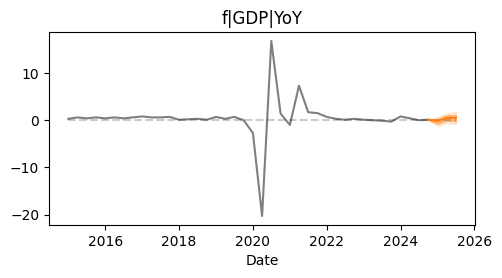

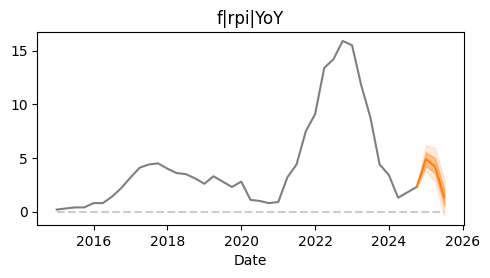

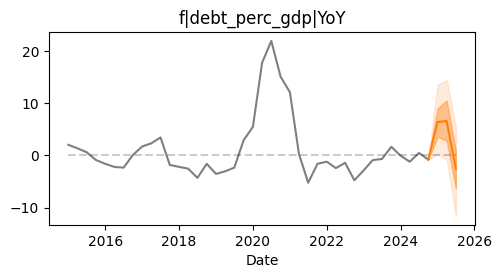

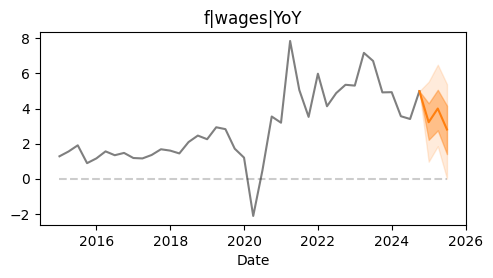

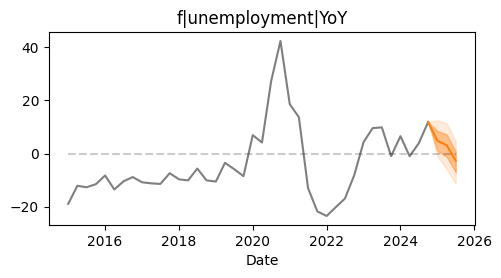

In [40]:
plot_from = -40
for v in range(len(variables)):

    # Get dates for plotting
    old_dates = pd.to_datetime(df['Quarter'])
    new_dates = pd.Series([old_dates.iloc[-1] + pd.DateOffset(months=3*n) for n in range(n_steps+1)])
    
    # Extract old values
    old_vals = df[variables[v]].values

    # Extract new values (and add previous point)
    new_vals = pred_med[:,v]
    new_vals = np.concat([[old_vals[-1]], new_vals])
    new_1s_min = np.concat([[old_vals[-1]], pred_1_sig_min[:,v]])
    new_1s_max = np.concat([[old_vals[-1]], pred_1_sig_max[:,v]])
    new_2s_min = np.concat([[old_vals[-1]], pred_2_sig_min[:,v]])
    new_2s_max = np.concat([[old_vals[-1]], pred_2_sig_max[:,v]])


    # Plot from
    if plot_from is not None:
        old_dates = old_dates[plot_from:]
        old_vals = old_vals[plot_from:]

    plt.figure(figsize=(5.5,2.5));
    plt.title(variables[v])
    plt.xlabel('Date')
    plt.hlines(0,old_dates.iloc[0], new_dates.iloc[-1], color='k', alpha=0.2, linestyle='dashed')
    plt.plot(old_dates, old_vals, color='k',alpha=0.5)
    plt.plot(new_dates, new_vals, color='C1')
    plt.fill_between(new_dates, new_1s_min, new_1s_max, color='C1', alpha=0.4)
    plt.fill_between(new_dates, new_2s_min, new_2s_max, color='C1', alpha=0.15)

    # plt.ylim([np.percentile(old_vals, 5)*1.2,
    #           np.percentile(old_vals, 95)*1.2])
